### EV CHARGING SESSION PEAK CLASSFICATION


#### Problem Statement
1.1)As electric vehicle (EV) adoption grows, charging station congestion and power grid strain have become major challenges. Power grid operators and charging station providers struggle to balance energy demand during peak hours, leading to higher electricity costs, longer wait times, and inefficient energy distribution.

This project aims to build a machine learning model to classify whether an EV charging session occurs during peak or off-peak hours based on historical charging data. By accurately predicting peak demand, energy providers can optimize grid loads, charging stations can implement dynamic pricing, and EV users can plan charging sessions efficiently, reducing costs and wait times.

#### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


#### Import Dataset

In [6]:
df=pd.read_csv('ev_charging_patterns_expanded.csv')

In [7]:
df.head()

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_600,Hyundai Kona,62.997001,Station_392,New York,2024-01-25 23:00:00,2024-01-25 23:43:00,28.617156,1.117055,33.109107,44.989312,Evening,Sunday,79.763722,95.633501,213.981405,30.953817,3.933487,DC Fast Charger,Casual Driver
1,User_650,Nissan Leaf,41.509746,Station_333,Los Angeles,2024-01-28 01:00:00,2024-01-28 02:37:00,58.734715,1.014042,NaN,36.420588,Afternoon,Monday,30.891514,78.232356,69.376900,20.479129,6.924243,Level 2,Casual Driver
2,User_1297,Tesla Model 3,101.244212,Station_227,New York,2024-02-24 00:00:00,2024-02-24 00:44:00,10.704122,2.417657,41.770796,27.915100,Evening,Thursday,41.843931,77.884906,55.541835,9.158073,6.893031,Level 1,Casual Driver
3,User_627,BMW i3,51.612441,Station_460,New York,2024-01-27 02:00:00,2024-01-27 05:53:00,43.095142,1.099472,25.678722,6.897531,Evening,Wednesday,16.737425,97.238181,141.912543,21.290956,2.957488,DC Fast Charger,Commuter
4,User_203,Tesla Model 3,61.317393,Station_376,Los Angeles,2024-01-09 10:00:00,2024-01-09 10:51:00,71.979076,0.587025,47.224208,36.585396,Evening,Tuesday,81.162967,66.593677,190.159722,-9.381112,2.244959,Level 1,Long-Distance Traveler


In [8]:
df.shape

(20000, 20)

In [9]:
df.columns

Index(['User ID', 'Vehicle Model', 'Battery Capacity (kWh)',
       'Charging Station ID', 'Charging Station Location',
       'Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)',
       'Charging Duration (hours)', 'Charging Rate (kW)',
       'Charging Cost (USD)', 'Time of Day', 'Day of Week',
       'State of Charge (Start %)', 'State of Charge (End %)',
       'Distance Driven (since last charge) (km)', 'Temperature (°C)',
       'Vehicle Age (years)', 'Charger Type', 'User Type'],
      dtype='object')

In [10]:

# Convert datetime columns
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])

# Extract time-based features
df['Charging Start Hour'] = df['Charging Start Time'].dt.hour
df['Charging Start Day'] = df['Charging Start Time'].dt.day
df['Charging Start Month'] = df['Charging Start Time'].dt.month
df['Charging Start Weekday'] = df['Charging Start Time'].dt.day_name()

In [11]:
# Handle missing values
# Energy Consumed (kWh)
df['Energy Consumed (kWh)'].fillna(df['Charging Duration (hours)'] * df['Charging Rate (kW)'], inplace=True)
df['Energy Consumed (kWh)'].fillna(df.groupby('Vehicle Model')['Energy Consumed (kWh)'].transform('median'), inplace=True)

# Charging Rate (kW)
df['Charging Rate (kW)'].fillna(df['Energy Consumed (kWh)'] / df['Charging Duration (hours)'], inplace=True)
df['Charging Rate (kW)'].fillna(df.groupby('Charger Type')['Charging Rate (kW)'].transform('median'), inplace=True)

# Distance Driven

df['Distance Driven (since last charge) (km)'].fillna(df.groupby('Vehicle Model')['Distance Driven (since last charge) (km)'].transform('median'), inplace=True)


In [72]:
df.describe()

,Battery Capacity (kWh),Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charging Start Hour,Charging Start Day,Charging Start Month,Peak_Off_Peak
count,20000.000000,20000,20000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,74.528842,2024-01-28 11:09:19.260000,2024-01-28 13:22:51.017999872,43.505356,2.269531,25.979517,22.531677,49.056535,75.160947,153.569149,15.277879,3.608677,11.505750,14.474050,1.43585,0.292700
min,-0.305358,2024-01-01 00:00:00,2024-01-01 00:39:00,-3.288590,-0.006908,0.322923,-1.058246,-0.929461,5.603749,-6.562675,-12.562880,-0.418420,0.000000,1.000000,1.00000,0.000000
25%,61.150886,2024-01-14 17:00:00,2024-01-14 18:27:00,23.907577,1.397425,13.581807,13.293235,27.989650,62.086113,82.404323,2.778557,1.856107,5.000000,7.000000,1.00000,0.000000
50%,75.030198,2024-01-28 10:00:00,2024-01-28 11:17:00,43.082991,2.252773,25.356915,22.093794,48.007863,75.478907,155.147125,14.812690,3.836028,11.000000,14.000000,1.00000,0.000000
75%,85.902134,2024-02-11 06:00:00,2024-02-11 07:51:00,61.860934,3.115338,37.431361,31.607832,69.118268,88.204791,222.694039,28.122559,5.842565,18.000000,21.000000,2.00000,1.000000
max,194.992019,2024-02-24 23:00:00,2024-02-24 23:56:00,170.533723,7.731335,147.419594,70.239220,154.707466,179.389548,407.490686,74.287453,11.822507,23.000000,31.000000,2.00000,1.000000
std,20.660378,NaN,NaN,24.128933,1.063190,14.657016,10.768595,24.103747,17.107875,84.055300,14.856430,2.311320,6.930957,8.296787,0.49588,0.455013


#### DataCleaning

In [16]:
df_clean = df.drop(columns=[
    'User ID', 'Charging Station ID', 'Charging Station Location',
    'Charging Start Time', 'Charging End Time'
])
df_clean = df_clean.dropna(subset=['User Type'])


#### Detecting outliers using IQR Method

In [18]:
# Identify outliers using IQR method
numerical_features = ['Energy Consumed (kWh)', 'Charging Duration (hours)', 'Charging Rate (kW)']
outlier_indices = {}
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    outlier_indices[feature] = outliers
    print(f"{feature}: {len(outliers)} outliers detected")


Energy Consumed (kWh): 164 outliers detected
Charging Duration (hours): 98 outliers detected
Charging Rate (kW): 85 outliers detected


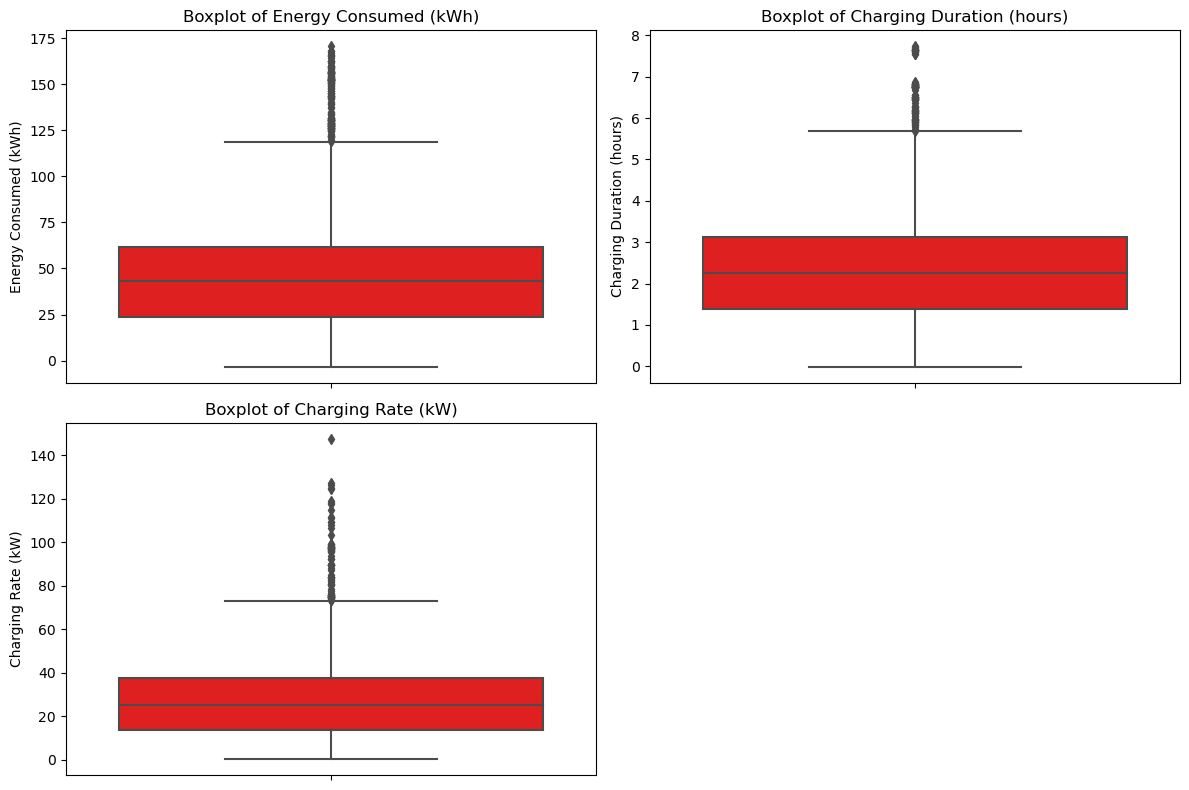

In [19]:
# Detect and visualize outliers
numerical_features = ['Energy Consumed (kWh)', 'Charging Duration (hours)', 'Charging Rate (kW)']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[feature], color='red')
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

#### Data Visualization

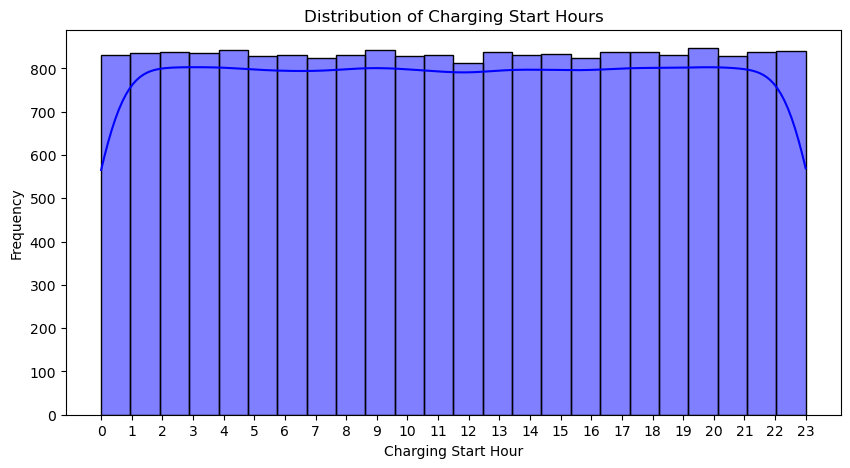

In [21]:
# Distribution of charging start hour
plt.figure(figsize=(10, 5))
sns.histplot(df['Charging Start Hour'], bins=24, kde=True, color="blue")
plt.xlabel("Charging Start Hour")
plt.ylabel("Frequency")
plt.title("Distribution of Charging Start Hours")
plt.xticks(range(0, 24))
plt.show()

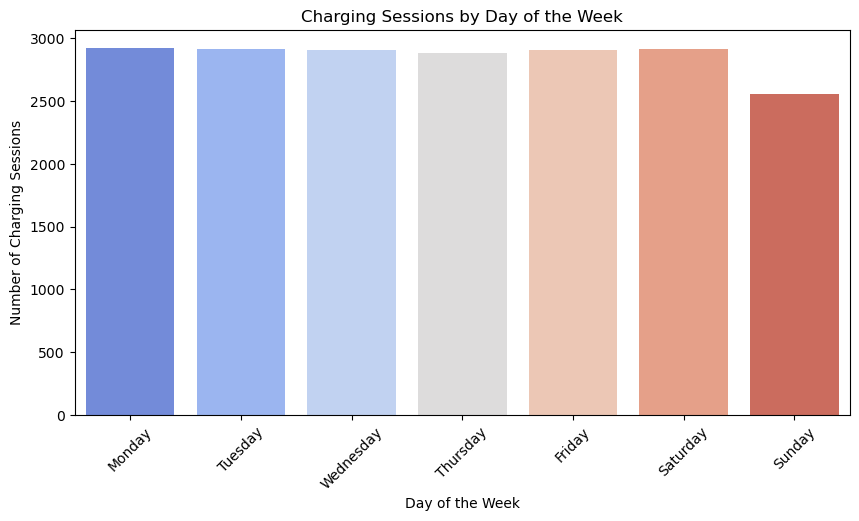

In [22]:
# Charging sessions by weekday
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Charging Start Weekday'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette="coolwarm")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Charging Sessions")
plt.title("Charging Sessions by Day of the Week")
plt.xticks(rotation=45)
plt.show()

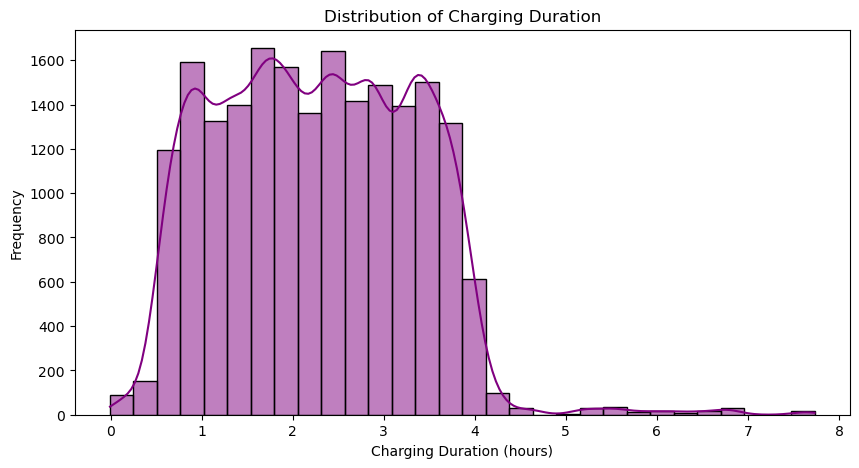

In [23]:
# Charging duration distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Charging Duration (hours)'], bins=30, kde=True, color="purple")
plt.xlabel("Charging Duration (hours)")
plt.ylabel("Frequency")
plt.title("Distribution of Charging Duration")
plt.show()

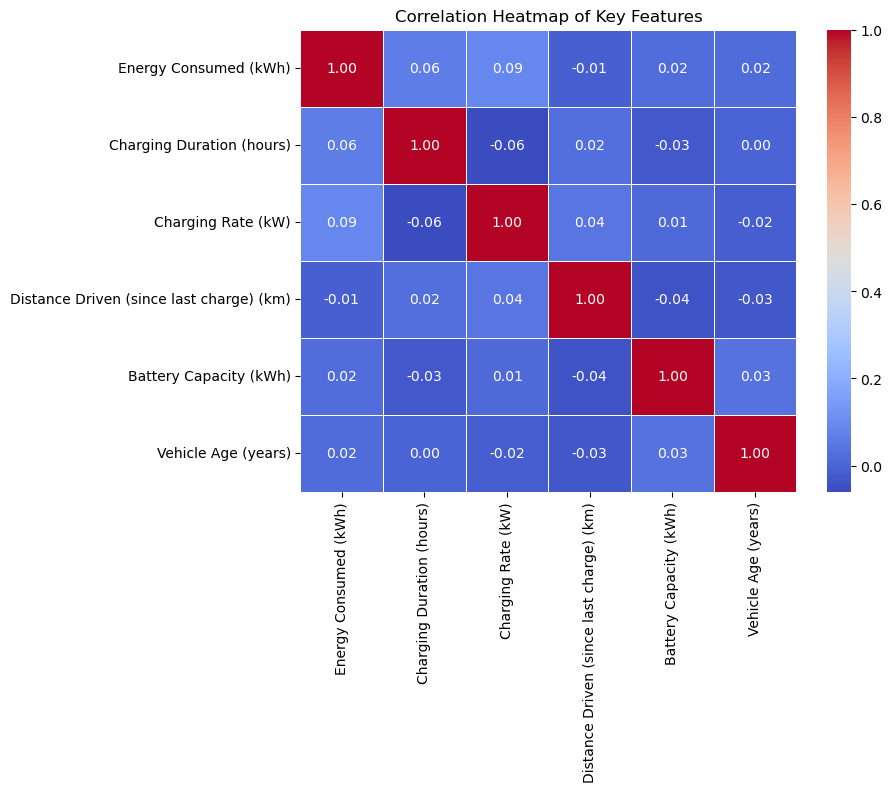

In [24]:
# Correlation heatmap
corr_matrix = df[['Energy Consumed (kWh)', 'Charging Duration (hours)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)', 'Battery Capacity (kWh)', 'Vehicle Age (years)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Key Features")
plt.show()

In [25]:
# Check class distribution (Time of Day)
print(df['Time of Day'].value_counts())

Time of Day
Evening      5439
Morning      5109
Night        4757
Afternoon    4695
Name: count, dtype: int64


In [26]:
## Standardization 
scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[numerical_features] = scaler.fit_transform(df[numerical_features])
print("Standardized Data Sample:")
print(df_standardized[numerical_features].head())

Standardized Data Sample:
   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)
0              -0.617042                  -1.084007            0.486441
1               0.631182                  -1.180900            2.179345
2              -1.359449                   0.139326            1.077414
3              -0.017001                  -1.100545           -0.020523
4               1.180095                  -1.582548            1.449492


In [27]:
# Feature Engineering: Peak vs. Off-Peak Classification
def classify_peak_off_peak(hour):
    return 'Peak' if 7 <= hour <= 9 or 17 <= hour <= 20 else 'Off-Peak'
df['Peak_Off_Peak'] = df['Charging Start Hour'].apply(classify_peak_off_peak)

In [28]:
# Check class distribution (Peak vs. Off-Peak)
print(df['Peak_Off_Peak'].value_counts())

Peak_Off_Peak
Off-Peak    14146
Peak         5854
Name: count, dtype: int64


In [29]:
from sklearn.feature_selection import SelectKBest, f_classif
label_encoder = LabelEncoder()
df['Peak_Off_Peak'] = label_encoder.fit_transform(df['Peak_Off_Peak']) 


X = df.select_dtypes(include=[np.number]).drop(columns=['Peak_Off_Peak'])  
y = df['Peak_Off_Peak']  


k = min(10, X.shape[1])  
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)


selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))


Selected Features: ['Battery Capacity (kWh)', 'Energy Consumed (kWh)', 'Charging Rate (kW)', 'Charging Cost (USD)', 'State of Charge (Start %)', 'State of Charge (End %)', 'Distance Driven (since last charge) (km)', 'Temperature (°C)', 'Vehicle Age (years)', 'Charging Start Hour']


In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [32]:
model = RandomForestClassifier(max_depth=8, n_estimators=120, min_samples_leaf=3, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=8, min_samples_leaf=3, n_estimators=120,
                       random_state=42)

In [33]:
y_pred = model.predict(X_test)


In [34]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc * 100, 2), "%")


Accuracy: 94.52 %


In [35]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2817
           1       1.00      0.81      0.90      1183

    accuracy                           0.95      4000
   macro avg       0.96      0.91      0.93      4000
weighted avg       0.95      0.95      0.94      4000



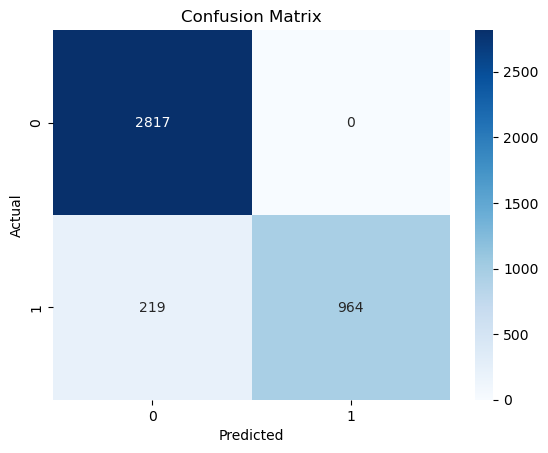

In [36]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [37]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.2339871791359518


In [38]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)


Mean Squared Error (MSE): 0.05475
R-squared (R²): 0.7371351512418114
